In [1]:
!pip install keras

In [2]:
# Import the tools we will need from keras and sklearn
#import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
import collections
import re
import string
import pandas as pd
import numpy as np
import nltk
nltk.download("popular")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |   

True

In [3]:
#Data Exploration
# reading the file using pandas and pass arguments to tell the function that the delimiter is tab
# and there is no header in our data file
data = pd.read_csv('imdb_labelled.tsv', header = None, delimiter='\t')

In [4]:
# setting the header
data.columns = ['Text', 'Label']

In [5]:
#check the header (output should show the specified column names in the previous cell)
data.head()

,Text,Label
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [6]:
data.Label.unique() # returns an array or list of unique values present in the 'Label' column of the 'data' dataset
data.shape #check the shape of the data
data.Label.value_counts()#Now we see the class distribution. We have 386 positive and 362 negative examples.

Label
1    386
0    362
Name: count, dtype: int64

In [7]:
# adding positive (1) and negative (0) labels to each instance
pos = []
neg = []
for l in data.Label:
    if l == 0:
         pos.append(0)
         neg.append(1)
    elif l == 1:
         pos.append(1)
         neg.append(0)

In [8]:
data['Pos']= pos
data['Neg']= neg
data.head()

,Text,Label,Pos,Neg
0,"A very, very, very slow-moving, aimless movie ...",0,0,1
1,Not sure who was more lost - the flat characte...,0,0,1
2,Attempting artiness with black & white and cle...,0,0,1
3,Very little music or anything to speak of.,0,0,1
4,The best scene in the movie was when Gerardo i...,1,1,0


In [9]:
#Data Cleaning
# removing non-alphabet characters or punctuations
def remove_punct(text):
    text_nopunct = ''
    text_nopunct = re.sub('['+string.punctuation+']', '', text)
    return text_nopunct
data['Text_Clean'] = data['Text'].apply(lambda x: remove_punct(x))

In [10]:
# Tokenization
from nltk import word_tokenize, WordNetLemmatizer
tokens = [word_tokenize(sen) for sen in data.Text_Clean]

# turn tokens into lower-case
def lower_token(tokens):
    return [w.lower() for w in tokens]
lower_tokens = [lower_token(token) for token in tokens]

In [11]:
#After lower casing the data, stop words are removed from data using NLTK’s stopwords
# getting stopwords in English
from nltk.corpus import stopwords
stoplist = stopwords.words('english')

In [14]:
# removing stop words
def remove_stop_words(tokens):
    return [word for word in tokens if word not in stoplist]

In [15]:
filtered_words = [remove_stop_words(sen) for sen in lower_tokens]
result = [' '.join(sen) for sen in filtered_words]
data['Text_Final'] = result
# adding the tokens to the dataset
data['tokens'] = filtered_words
data = data[['Text_Final', 'tokens', 'Label', 'Pos', 'Neg']]
data[:4]

,Text_Final,tokens,Label,Pos,Neg
0,slowmoving aimless movie distressed drifting y...,"[slowmoving, aimless, movie, distressed, drift...",0,0,1
1,sure lost flat characters audience nearly half...,"[sure, lost, flat, characters, audience, nearl...",0,0,1
2,attempting artiness black white clever camera ...,"[attempting, artiness, black, white, clever, c...",0,0,1
3,little music anything speak,"[little, music, anything, speak]",0,0,1


In [16]:
#Split Data into Test and Train
data_train, data_test = train_test_split(data, test_size=0.10, random_state=42)

In [17]:
# Then we build training vocabulary and get maximum training sentence length and total number of words training data.
all_training_words = [word for tokens in data_train["tokens"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in data_train["tokens"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_training_words),len(TRAINING_VOCAB)))
print("Max sentence length is %s" % max(training_sentence_lengths))

7218 words total, with a vocabulary size of 2881
Max sentence length is 789


In [18]:
# Same thing is done for testing data.
all_test_words = [word for tokens in data_test["tokens"] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in data_test["tokens"]]
TEST_VOCAB = sorted(list(set(all_test_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_test_words),
len(TEST_VOCAB)))
print("Max sentence length is %s" % max(test_sentence_lengths))

580 words total, with a vocabulary size of 457
Max sentence length is 24


In [20]:
from __future__ import division, print_function
from gensim import models
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Embedding
from keras.layers import LSTM
from keras.models import Sequential
#from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Model

In [25]:
!pip install gensim

In [26]:
from gensim.models import KeyedVectors

In [28]:
from gensim.models import KeyedVectors

# Path to the pre-trained Word2Vec model
word2vec_path = "GoogleNews-vectors-negative300.bin.gz"

# Limit the number of vectors to load
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=500000)

# Verify if the model is loaded correctly
print("Model loaded successfully.")


Model loaded successfully.


In [29]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word
in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged
def get_word2vec_embeddings(vectors, clean_comments, generate_missing=False):
    embeddings = clean_comments['tokens'].apply(lambda x: get_average_word2vec(x,
vectors, generate_missing=generate_missing))
    return list(embeddings)

In [30]:
#Get Embeddings
training_embeddings = get_word2vec_embeddings(word2vec, data_train,
generate_missing=True)

In [31]:
'''For example if we have a sentence “How text to sequence and padding works”. Each word is assigned a number. We suppose how = 1, text = 2, to = 3, sequence =4, and = 5, padding = 6, works = 7. After
texts_to_sequences is called our sentence will look like [1, 2, 3, 4, 5, 6, 7 ]. Now we suppose our MAX_SEQUENCE_LENGTH = 10. After padding our sentence will look like [0, 0, 0, 1, 2, 3, 4, 5, 6, 7 ] '''
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 300

In [33]:
tokenizer = Tokenizer(num_words=len(TRAINING_VOCAB), lower=True, char_level=False)
tokenizer.fit_on_texts(data_train["Text_Final"].tolist())
training_sequences = tokenizer.texts_to_sequences(data_train["Text_Final"].tolist())
train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))
train_cnn_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

Found 2881 unique tokens.


In [35]:
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)
test_sequences = tokenizer.texts_to_sequences(data_test["Text_Final"].tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

(2882, 300)


In [36]:
label_names = ['Pos', 'Neg'] # labels
y_train = data_train[label_names].values
y_test = data_test[label_names].values
print(y_train)

[[1 0]
 [0 1]
 [0 1]
 ...
 [1 0]
 [0 1]
 [0 1]]


In [37]:
labels_index = len(list(label_names))
print(labels_index)

2


In [39]:
num_words = len(train_word_index)+1
max_sequence_length = 50
embedding_dim = 300
embeddings = train_embedding_weights
embedding_layer = Embedding(num_words, embedding_dim,trainable=False)

In [40]:
#Build the embedding layer and set the weights to the Word2Vec weights.
embedding_layer.build((1,))
embedding_layer.set_weights([embeddings])

In [41]:
#Construct the model
sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
conv_1 = Conv1D(filters=200, kernel_size=2, activation='relu')(embedded_sequences)
pool_1 = MaxPooling1D()(conv_1)
conv_2 = Conv1D(filters=200, kernel_size=3, activation='relu')(pool_1)
pool_2 = MaxPooling1D()(conv_2)
flattening = Flatten()(pool_2)
dp_1 = Dropout(0.1)(flattening)
dense_1 = Dense(128, activation='relu')(dp_1)
dp_2= Dropout(0.1)(dense_1)
out = Dense(labels_index, activation='sigmoid')(dp_2)

In [42]:
model = Model(inputs = sequence_input, outputs = out)

In [44]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 50, 300)        │       864,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 49, 200)        │       120,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 24, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 22, 200)        │       120,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 11, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       281,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,386,986 (5.29 MB)

 Trainable params: 522,386 (1.99 MB)

 Non-trainable params: 864,600 (3.30 MB)

In [45]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
early_stopping_monitor = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
# use this to apply a stopping criterion of 5 for the training epochs based on validation loss
#the training will stop if after 5 epochs there is no improvement in validation loss and will save best model in model_file

In [46]:
model_file = 'best_CNN_model.keras'

In [47]:
model_check_point = ModelCheckpoint(model_file, monitor='val_loss', mode='min',
verbose=1, save_best_only=True)

In [48]:
hist = model.fit(train_cnn_data, y_train, epochs=20, batch_size=32, verbose=1,
validation_split=0.1, callbacks=[early_stopping_monitor, model_check_point])

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - acc: 0.5219 - loss: 0.6859
Epoch 1: val_loss improved from inf to 0.65346, saving model to best_CNN_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - acc: 0.5240 - loss: 0.6856 - val_acc: 0.6765 - val_loss: 0.6535
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - acc: 0.7054 - loss: 0.6276
Epoch 2: val_loss improved from 0.65346 to 0.63624, saving model to best_CNN_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - acc: 0.7069 - loss: 0.6256 - val_acc: 0.6912 - val_loss: 0.6362
Epoch 3/20
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - acc: 0.8099 - loss: 0.4566
Epoch 3: val_loss did not improve from 0.63624
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - acc: 0.8119 - loss: 0.4531 - val_acc: 0.7059 - val_loss: 0.6656
Epoch 4/20
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - acc: 0.8723 - loss: 0.2745
Epoch 4: val_loss improved from 0.63624 to 0.48660, saving model to best_CNN_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - acc: 0.873

In [49]:
#load the best saved model
from keras.models import load_model
model = load_model('best_CNN_model.keras')

In [50]:
# Test the model on the test data after training
test_results = model.evaluate(test_cnn_data, y_test, verbose=1)
print(f'Test results - Accuracy: {test_results[1]*100: .2f}%')

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - acc: 0.7205 - loss: 0.4834
Test results - Accuracy:  70.67%


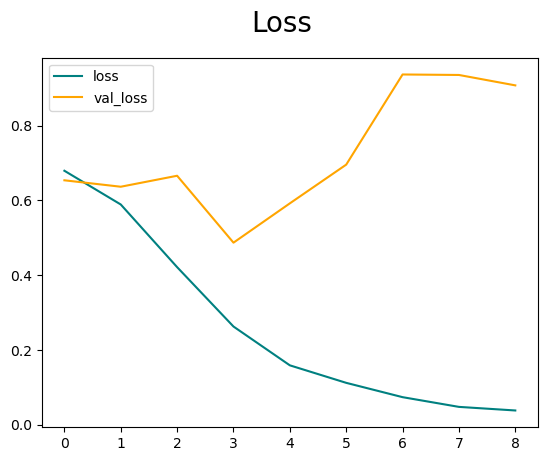

In [51]:
from matplotlib import pyplot as plt
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [52]:
#Construct the model
sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
conv_1 = Conv1D(filters=300, kernel_size=2, activation='relu')(embedded_sequences)
pool_1 = MaxPooling1D()(conv_1)
conv_2 = Conv1D(filters=300, kernel_size=3, activation='relu')(pool_1)
pool_2 = MaxPooling1D()(conv_2)
flattening = Flatten()(pool_2)
dp_1 = Dropout(0.1)(flattening)
dense_1 = Dense(128, activation='relu')(dp_1)
dp_2= Dropout(0.1)(dense_1)
out = Dense(labels_index, activation='sigmoid')(dp_2)

In [53]:
model = Model(inputs = sequence_input, outputs = out)

In [54]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 50, 300)        │       864,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 49, 300)        │       180,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 24, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 22, 300)        │       270,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 11, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3300)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3300)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       422,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,737,986 (6.63 MB)

 Trainable params: 873,386 (3.33 MB)

 Non-trainable params: 864,600 (3.30 MB)

In [56]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
early_stopping_monitor = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
# use this to apply a stopping criterion of 5 for the training epochs based on validation loss
#the training will stop if after 5 epochs there is no improvement in validation loss and will save best model in model_file

In [57]:
model_file = 'best_CNN_model2.keras'

In [59]:
model_check_point = ModelCheckpoint(model_file, monitor='val_loss', mode='min',
verbose=1, save_best_only=True)
hist = model.fit(train_cnn_data, y_train, epochs=20, batch_size=32, verbose=1,
validation_split=0.1, callbacks=[early_stopping_monitor, model_check_point])

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - acc: 0.5618 - loss: 0.6913
Epoch 1: val_loss improved from inf to 0.64139, saving model to best_CNN_model2.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - acc: 0.5626 - loss: 0.6911 - val_acc: 0.6765 - val_loss: 0.6414
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - acc: 0.6952 - loss: 0.6402
Epoch 2: val_loss improved from 0.64139 to 0.60131, saving model to best_CNN_model2.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - acc: 0.6963 - loss: 0.6387 - val_acc: 0.7206 - val_loss: 0.6013
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - acc: 0.8390 - loss: 0.4089
Epoch 3: val_loss improved from 0.60131 to 0.57955, saving model to best_CNN_model2.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - acc: 0.8398 - loss: 0.4072 - val_acc: 0.7059 - val_loss: 0.5795
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - acc: 0.9009 - loss: 0.2396
Epoch 4: val_loss improved from 0.57955 to 0.57174, saving model to best_CNN_model2.keras
19/19 

In [60]:
from keras.models import load_model
model = load_model('best_CNN_model2.keras')
# Test the model on the test data after training
test_results = model.evaluate(test_cnn_data, y_test, verbose=1)
print(f'Test results - Accuracy: {test_results[1]*100: .2f}%')

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - acc: 0.7244 - loss: 0.5483
Test results - Accuracy:  70.67%


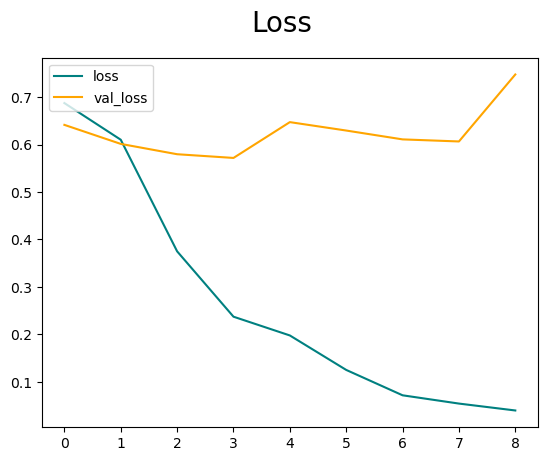

In [61]:
from matplotlib import pyplot as plt
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()